# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from scipy import stats
import seaborn as sns
sns.set(style="whitegrid")

## Import Data

In [2]:
#Read in data
df = pd.read_csv('./data/kc_house_data_train.csv')
holdout = pd.read_csv('./data/kc_house_data_test_features.csv')

In [3]:
#Drop Unnamed and id columns
df = df.drop(['Unnamed: 0','id'],axis=1)
holdout = holdout.drop(['Unnamed: 0','id'],axis=1)

## Exploratory Data Analysis 
    

First, I review the correlation between all the features within our dataset. Normally, we review for collinearity within these charts, but for now, we can initially see which variables have the strongest relationship with 'price'.

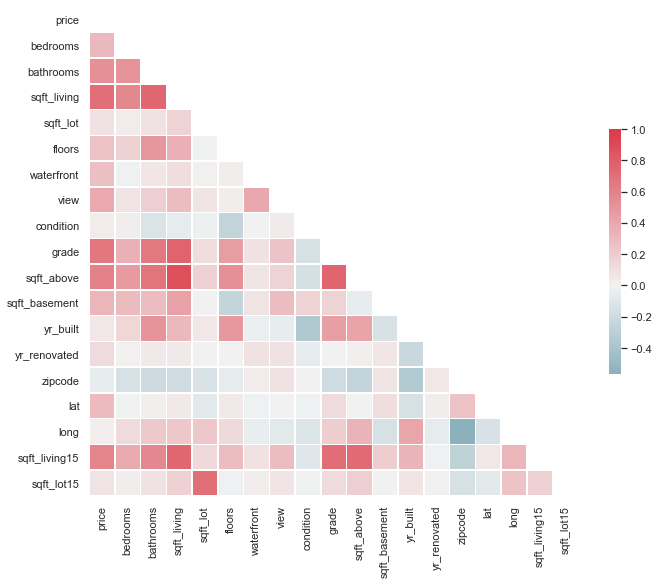

In [4]:
#style setting
sns.set(style="white")

# Calculate correlation
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib\
f, ax = plt.subplots(figsize=(11, 9))

# Use colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

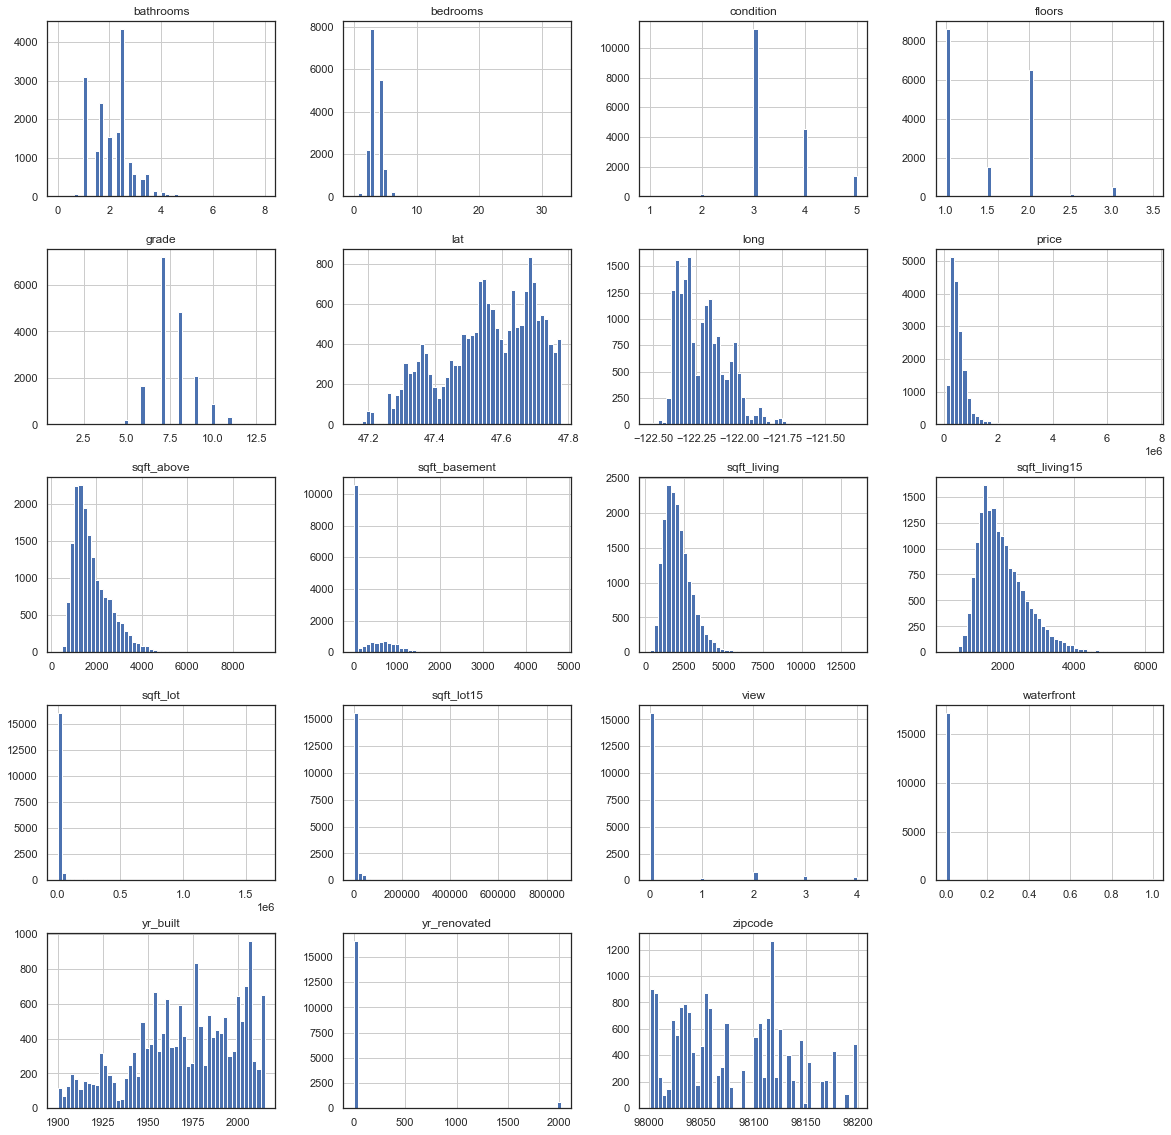

In [5]:
df.hist(bins=50,figsize=(20,20))
plt.show()

### Relationship between House Prices and Sqft of Living Space

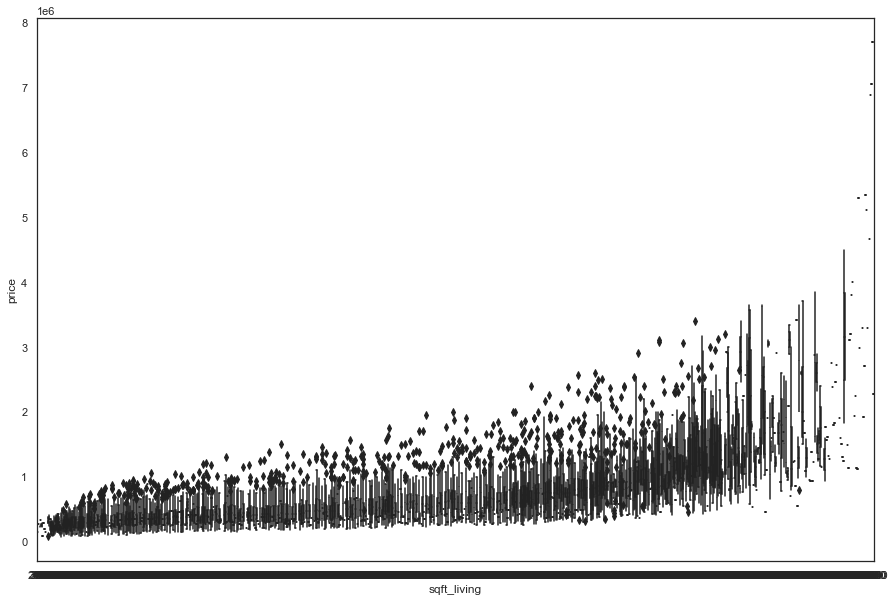

In [54]:
#Plotting house prices vs sqft_living
fig,axes=plt.subplots(1,1,figsize=(15,10))
sns.boxplot(x='sqft_living',y='price',data=df,palette="Blues");

### Relationship between House Prices and Number of Bathrooms

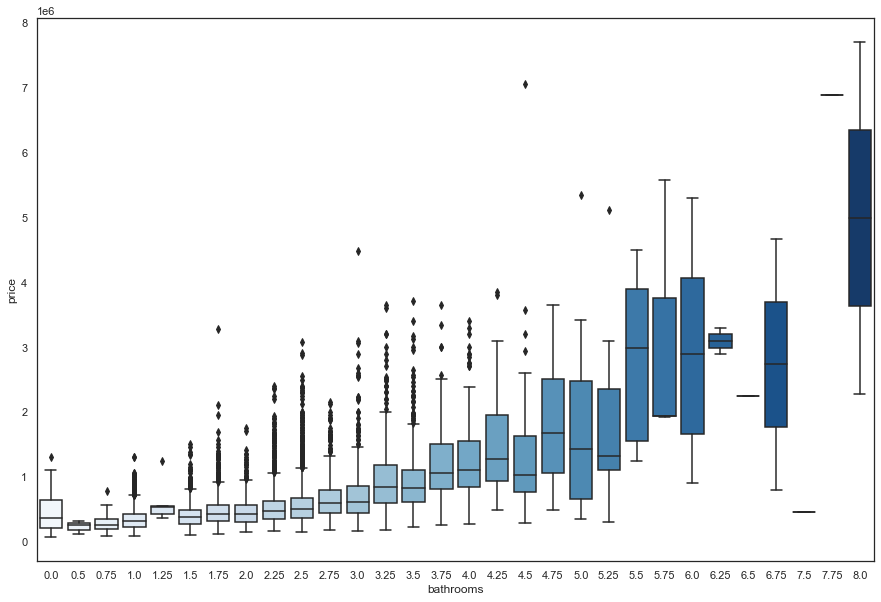

In [7]:
#Plotting house prices vs # of bathrooms
fig,axes=plt.subplots(1,1,figsize=(15,10))
sns.boxplot(x='bathrooms',y='price',data=df,palette="Blues");

### Relationship between House Prices and Number of Bedrooms

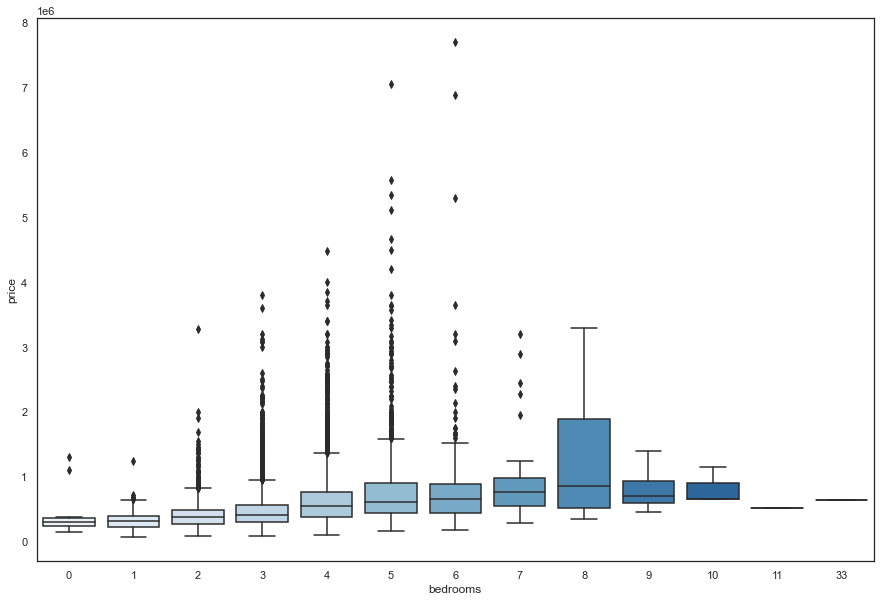

In [8]:
#Plotting house prices vs # of bedrooms
fig,axes=plt.subplots(1,1,figsize=(15,10))
sns.boxplot(x='bedrooms',y='price',data=df,palette="Blues");

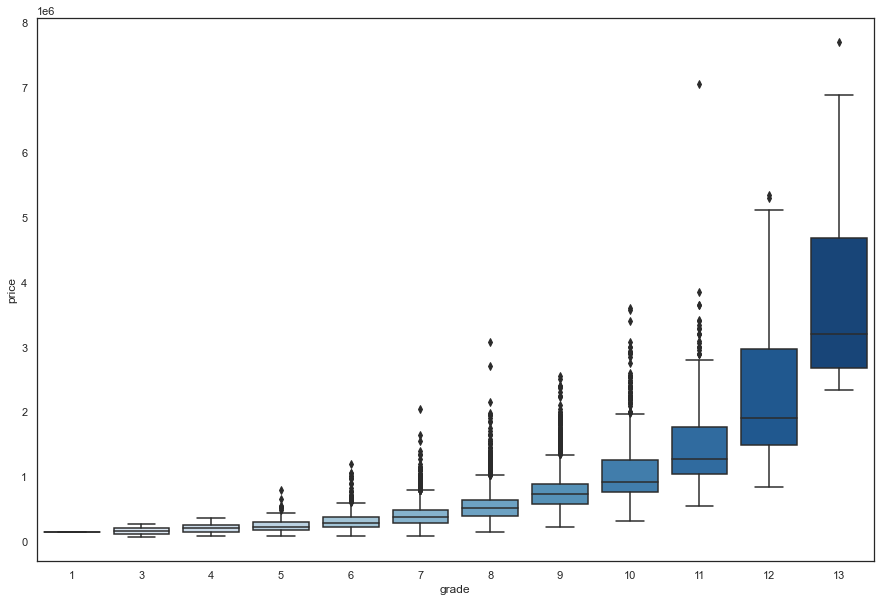

In [88]:
#Plotting grades vs sqft_living
fig,axes=plt.subplots(1,1,figsize=(15,10))
sns.boxplot(x='grade',y='price',data=df,palette="Blues");

## Date Adjustment and Data Cleanup

In [10]:
#Date Conversion
df['month'] = df['date'].str[4:6]
df['month'] = pd.to_numeric(df['month'],errors='coerce')
df = df.drop(['date'],axis=1)
holdout['month'] = holdout['date'].str[4:6]
holdout['month'] = pd.to_numeric(holdout['month'],errors='coerce')
holdout = holdout.drop(['date'],axis=1)

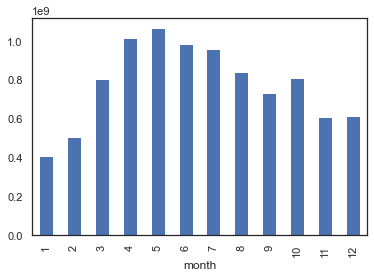

In [11]:
df.groupby(['month']).price.sum().plot(kind='bar');

In [12]:
#Check data for any NA values
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
month            0
dtype: int64

In [55]:
#Reviewing data further for outliers
df['bedrooms'].value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
Name: bedrooms, dtype: int64

In [58]:
#Outlier Data in Bedrooms removed
df = df[df['bedrooms']<=10]
holdout = holdout[holdout['bedrooms']<=10]

## Initial Linear Regression

Create a linear regression plot using all basic data in the initial dataset

In [59]:
target = df['price']
features = df.columns.drop(['price'])
df_features = df[features]
df_features

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,month,years_old,renovated,bedrooms^2,bathrooms^2,sqft^2
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,...,47.4388,-122.162,2390,7700,10,29,0,16,5.0625,4284900
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,...,47.6784,-122.285,2370,6283,8,38,0,25,9.0000,8410000
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,...,47.5646,-122.129,3710,9685,8,18,0,16,6.2500,14212900
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,...,47.6995,-122.228,4050,14226,3,25,0,9,12.2500,20793600
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,...,47.6647,-122.083,2250,4050,7,11,0,9,6.2500,6502500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,5,2.50,3240,9960,1.0,0,1,3,8,2020,...,47.5858,-122.112,2730,10400,3,57,0,25,6.2500,10497600
17286,2,1.75,1300,4000,2.0,0,0,3,7,1300,...,47.6687,-122.288,1350,4013,5,67,0,4,3.0625,1690000
17287,3,1.00,1050,9876,1.0,0,0,3,7,1050,...,47.7635,-122.262,1760,9403,5,62,0,9,1.0000,1102500
17288,3,1.50,1900,43186,1.5,0,0,4,7,1300,...,47.4199,-121.990,2080,108028,12,44,0,9,2.2500,3610000


In [60]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9,test_size=0.2)

#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 188490.59015950456


## Additional Feature Generation

### Create Dummy Variables for Zipcode

In [61]:
#ziplist = df['zipcode'].tolist()
#ziplist_series = pd.Series(ziplist)
#ziplist_final = ziplist_series.astype('category')
#zip_dummies = pd.get_dummies(ziplist_final)
#df = pd.concat([df,zip_dummies], axis=1)
#df = df[df['bedrooms'].notna()]

### Create new years_old column from yr_built column

In [62]:
#Years Old column created
df['years_old'] = 2015-df['yr_built']
holdout['years_old'] = 2015-holdout['yr_built']

### Create new renovated column from yr_renovated column

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,month,years_old,renovated,bedrooms^2,bathrooms^2,sqft^2
0,4,2.50,2270,11500,1.0,0,0,3,8,1540,...,47.7089,-122.241,2020,10918,8,48,0,16,6.2500,5152900
1,4,2.50,2270,11500,1.0,0,0,3,8,1540,...,47.7089,-122.241,2020,10918,2,48,0,16,6.2500,5152900
2,3,2.50,1470,1779,2.0,0,0,3,8,1160,...,47.5472,-121.998,1470,1576,11,10,0,9,6.2500,2160900
3,3,1.75,1280,16200,1.0,0,0,3,8,1030,...,47.7427,-122.071,1160,10565,12,39,0,9,3.0625,1638400
4,4,2.75,2830,8126,2.0,0,0,3,8,2830,...,47.4863,-122.140,2830,7916,1,10,0,16,7.5625,8008900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4318,3,2.50,1530,1131,3.0,0,0,3,8,1530,...,47.6993,-122.346,1530,1509,5,6,0,9,6.2500,2340900
4319,4,2.50,2310,5813,2.0,0,0,3,8,2310,...,47.5107,-122.362,1830,7200,2,1,0,16,6.2500,5336100
4320,2,0.75,1020,1350,2.0,0,0,3,7,1020,...,47.5944,-122.299,1020,2007,6,6,0,4,0.5625,1040400
4321,3,2.50,1600,2388,2.0,0,0,3,8,1600,...,47.5345,-122.069,1410,1287,1,11,0,9,6.2500,2560000


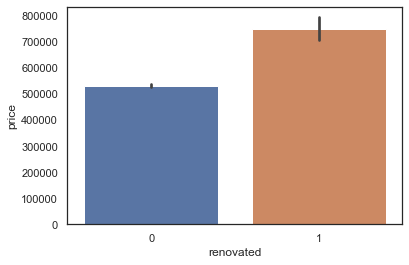

In [63]:
#Renovated Year column converted to binary variable "Renovated"
df['renovated'] = df['yr_renovated'].apply(lambda x: 1 if x != 0 else 0)
sns.barplot(x='renovated',y='price',data=df);
df.drop('yr_renovated',axis=1)
holdout['renovated'] = holdout['yr_renovated'].apply(lambda x: 1 if x != 0 else 0)
holdout.drop('yr_renovated',axis=1)

In [64]:
#Test statistical significance of newly created renovated value
stat= stats.ttest_ind(df[df.renovated == 1].price,
                df[df.renovated == 0].price, 
                equal_var=False)
print(f'T-Test shows a stastically significant difference between the mean of homes that have gone through renovations compared to those without with a p_value of {stat[1]}')

T-Test shows a stastically significant difference between the mean of homes that have gone through renovations compared to those without with a p_value of 6.390567577920582e-20


In [65]:
target = df['price']
features = df.columns.drop(['price'])
df_features = df[features]


holdout_features = holdout[features]

In [66]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_features, target, random_state=9,test_size=0.2)

#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train2, y_train2)

y_train2_pred = lm.predict(X_train2)

train2_rmse = np.sqrt(metrics.mean_squared_error(y_train2, y_train2_pred))

print('Training Root Mean Squared Error:' , train2_rmse)

Training Root Mean Squared Error: 188490.59015950456


## Non-linear transformations

Test the polynomial nature of bedrooms, bathrooms,sqft of living on the price as these were some of the strongest predictors of price.

In [67]:
df2 = df
df2['bedrooms^2'] = df['bedrooms']**2
df2['bathrooms^2'] = df['bathrooms']**2
df2['sqft^2'] = df['sqft_living']**2
holdout2 = holdout
holdout2['bedrooms^2'] = holdout['bedrooms']**2
holdout2['bathrooms^2'] = holdout['bathrooms']**2
holdout2['sqft^2'] = holdout['sqft_living']**2

In [68]:
target2 = df2['price']
features = df2.columns.drop(['price'])
df2_features = df2[features]

In [69]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(df2_features, target2, random_state=9,test_size=0.2)

#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train3, y_train3)

y_train3_pred = lm.predict(X_train3)

train3_rmse = np.sqrt(metrics.mean_squared_error(y_train3, y_train_pred))

print('Training Root Mean Squared Error:' , train3_rmse)

Training Root Mean Squared Error: 188490.59015950456


In [70]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()


poly2_data = poly_2.fit_transform(holdout_features)
poly2_columns = poly_2.get_feature_names(holdout_features.columns)
holdout_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
holdout_poly2.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,renovated^2,renovated bedrooms^2,renovated bathrooms^2,renovated sqft^2,bedrooms^2^2,bedrooms^2 bathrooms^2,bedrooms^2 sqft^2,bathrooms^2^2,bathrooms^2 sqft^2,sqft^2^2
0,4.0,2.50,2270.0,11500.0,1.0,0.0,0.0,3.0,8.0,1540.0,...,0.0,0.0,0.0,0.0,256.0,100.0000,82446400.0,39.062500,32205625.00,2.655238e+13
1,4.0,2.50,2270.0,11500.0,1.0,0.0,0.0,3.0,8.0,1540.0,...,0.0,0.0,0.0,0.0,256.0,100.0000,82446400.0,39.062500,32205625.00,2.655238e+13
2,3.0,2.50,1470.0,1779.0,2.0,0.0,0.0,3.0,8.0,1160.0,...,0.0,0.0,0.0,0.0,81.0,56.2500,19448100.0,39.062500,13505625.00,4.669489e+12
3,3.0,1.75,1280.0,16200.0,1.0,0.0,0.0,3.0,8.0,1030.0,...,0.0,0.0,0.0,0.0,81.0,27.5625,14745600.0,9.378906,5017600.00,2.684355e+12
4,4.0,2.75,2830.0,8126.0,2.0,0.0,0.0,3.0,8.0,2830.0,...,0.0,0.0,0.0,0.0,256.0,121.0000,128142400.0,57.191406,60567306.25,6.414248e+13


In [71]:
x_train4, x_test4, y_train4, y_test4 = train_test_split(df_poly2, target, random_state=42,test_size=0.2)

In [72]:
# instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(x_train4, y_train4)

y_train4_pred = lm_2.predict(x_train4)
y_test4_pred = lm_2.predict(x_test4)

train4_rmse = np.sqrt(metrics.mean_squared_error(y_train4, y_train4_pred))
test4_rmse = np.sqrt(metrics.mean_squared_error(y_test4, y_test4_pred))
print('Training Root Mean Squared Error:' , train4_rmse)
print('Testing Root Mean Squared Error:' , test4_rmse)

Training Root Mean Squared Error: 164294.41515925006
Testing Root Mean Squared Error: 225326.6325523165


The poly2 model has outperformed all previous models with a RSME Of 149030.28645023465

In [73]:
poly_3 = PolynomialFeatures(degree=3, include_bias=False)
poly3_data = poly_3.fit_transform(df_features)
poly3_columns = poly_3.get_feature_names(df_features.columns)
df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)
df_poly3.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,bedrooms^2^3,bedrooms^2^2 bathrooms^2,bedrooms^2^2 sqft^2,bedrooms^2 bathrooms^2^2,bedrooms^2 bathrooms^2 sqft^2,bedrooms^2 sqft^2^2,bathrooms^2^3,bathrooms^2^2 sqft^2,bathrooms^2 sqft^2^2,sqft^2^3
0,4.0,2.25,2070.0,8893.0,2.0,0.0,0.0,4.0,8.0,2070.0,...,4096.0,1296.00,1.096934e+09,410.0625,3.470769e+08,2.937659e+14,129.746338,1.098173e+08,9.294936e+13,7.867234e+19
1,5.0,3.00,2900.0,6730.0,1.0,0.0,0.0,5.0,8.0,1830.0,...,15625.0,5625.00,5.256250e+09,2025.0000,1.892250e+09,1.768202e+15,729.000000,6.812100e+08,6.365529e+14,5.948233e+20
2,4.0,2.50,3770.0,10893.0,2.0,0.0,2.0,3.0,11.0,3770.0,...,4096.0,1600.00,3.638502e+09,625.0000,1.421290e+09,3.232104e+15,244.140625,5.551914e+08,1.262541e+15,2.871099e+21
3,3.0,3.50,4560.0,14608.0,2.0,0.0,2.0,3.0,12.0,4560.0,...,729.0,992.25,1.684282e+09,1350.5625,2.292494e+09,3.891364e+15,1838.265625,3.120340e+09,5.296579e+15,8.990608e+21
4,3.0,2.50,2550.0,5376.0,2.0,0.0,0.0,3.0,9.0,2550.0,...,729.0,506.25,5.267025e+08,351.5625,3.657656e+08,3.805426e+14,244.140625,2.540039e+08,2.642657e+14,2.749420e+20


In [74]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(df_poly3, target, random_state=9,test_size=0.2)

In [75]:
# instantiate a linear regression object
lm_3 = LinearRegression()

#fit the linear regression to the data
lm_3 = lm_3.fit(X_train5, y_train5)

y_train5_pred = lm_3.predict(X_train5)

train5_rmse = np.sqrt(metrics.mean_squared_error(y_train5, y_train5_pred))

print('Training Root Mean Squared Error:' , train5_rmse)

Training Root Mean Squared Error: 148844.75525783692


The poly3 table has the highest RSME value however, the data becomes convoluted and creates too many columns. I believe this model is not going to be reasonable and the poly2 model is superior.

## F Test

Determine Best Features to Narrow down to Top 20 Variables. Review results and compare vs. original model.

In [76]:
x_train4.shape

(13830, 324)

In [77]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=20)

selector.fit(x_train4, y_train4)

SelectKBest(k=20, score_func=<function f_regression at 0x000001D71A456550>)

In [78]:
selected_columns = x_train4.columns[selector.get_support()]
removed_columns = x_train4.columns[~selector.get_support()]

In [79]:
lm_kbest = LinearRegression()

lm_kbest = lm_kbest.fit(x_train4[selected_columns], y_train4)

y_train_kbest = lm_kbest.predict(x_train4[selected_columns])


trainK4_rmse = np.sqrt(metrics.mean_squared_error(y_train4, y_train_kbest))

print('Training Root Mean Squared Error:' , trainK4_rmse)

y_kbest = lm_kbest.predict(x_test4[selected_columns])

testK4_rmse = np.sqrt(metrics.mean_squared_error(y_test4, y_kbest))

print('Testing Root Mean Squared Error:' , testK4_rmse)


Training Root Mean Squared Error: 184344.25661522473
Testing Root Mean Squared Error: 195872.5547599373


In [80]:
print('Original: ', test4_rmse, '\n',
      "KBest:   ", testK4_rmse,'\n')
print("Original has a lower RSME than KBest")

Original:  225326.6325523165 
 KBest:    195872.5547599373 

Original has a lower RSME than KBest


## Final Model

Final steps involve fittign the data to the entire dataset. Next, we save the model. Then, we load the model and apply it to the holdout set.

In [81]:
#Instantiate a linear regression object
lm_final = LinearRegression()

#Fit the linear regression to the data
lm_final = lm_final.fit(df_poly2, target)

In [82]:
#Generate Coefficients
lm_final.coef_

array([ 1.39947023e+04, -7.93460318e+01,  6.43752095e+00,  6.36399142e-01,
       -2.41852720e+01, -3.28366999e+00,  2.19073655e+00,  4.02073033e+00,
       -1.33591249e+00,  8.58751751e-02, -5.82397383e-02,  4.92270553e-03,
       -3.47800088e-02, -1.63550610e-02,  5.01945680e+01, -2.15464000e+00,
        6.06987295e-03, -6.56948298e-03, -5.94255028e-01,  2.91476025e-02,
       -1.16335964e-02, -1.89606295e-01, -2.15687366e+00, -1.42421481e-02,
       -1.98990351e-01,  6.55724472e+03, -5.39697877e+01,  1.14330048e-01,
        1.00491035e+04, -2.42294524e+03, -5.21877819e+04,  2.07576459e+04,
        1.44617619e+04, -2.71155364e+01, -2.68524854e+01,  9.38255640e+03,
       -3.27642846e+01, -1.95613840e+02,  8.44796213e+02, -6.82362735e+02,
        4.57365294e+01, -2.25626089e-01, -7.32928775e+02,  1.04023520e+04,
       -7.96245916e+01,  3.11916704e+03,  8.32633826e+03,  9.23512720e-03,
       -2.16048766e+00, -2.41098710e+00,  3.44780007e-01, -1.55076083e+02,
        5.40089677e+03,  

In [83]:
#Save My Model
import pickle

pickle_out = open("lm_final.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

In [84]:
#Load Model
price_prediction_model = pickle.load(open("lm_final.pickle","rb"))

In [85]:
#Apply to Holdout Data
price_prediction = price_prediction_model.predict(holdout_poly2)

In [86]:
#Export to CSV
final_answer_df = pd.DataFrame(price_prediction,columns=['holdout_prices'])
final_answer_df.to_csv('King_County_Final_predictions.csv')

Final has been exported!